# Load dataset

In [ ]:
from keras.datasets.fashion_mnist import load_data
(x_train,y_train), (_,_) = load_data()
x_train = x_train/255 *2 -1
x_train = x_train.reshape(-1,28,28,1)

4423680/4422102 [==============================] - 0s 0us/step


# Generator model
In this model convolutional layers are used to generate image from input label and noise.

In [ ]:
from keras.models import Model
from keras.layers import Input,Dense,LeakyReLU,Conv2DTranspose,Conv2D
from keras.layers import Flatten,Concatenate,Reshape,Embedding
from keras.utils import plot_model
from keras.optimizers import Adam,RMSprop
latent_dim = 100
label = Input(shape=(1),name='label')
# using embedding layer for label
x = Embedding(10, 50)(label)
x = Dense(7*7)(x)
x = Reshape((7, 7, 1))(x)
# noise input
z = Input(shape=(latent_dim),name='noise')
y = Dense(50*7*7)(z)
y = LeakyReLU(alpha=0.2)(y)
y = Reshape((7, 7, 50))(y)
# concatenation of embedded label to noise input
merge = Concatenate()([y, x])
# deconvolution layers to make image output
y = Conv2DTranspose(50,4,2,padding='same')(merge)
y = LeakyReLU(alpha=0.2)(y)
y = Conv2DTranspose(50,4,2,padding='same')(y)
y = LeakyReLU(alpha=0.2)(y)
# output layer
output = Conv2D(1,7,activation='tanh', padding='same')(y)
generator = Model([z, label], output)
generator._name = 'generator'
# plot_model(generator,show_shapes=True,dpi=300)

# Discriminator model
Determinig wheter genrated image is fake or real.

In [ ]:
# using embedding layer for label
x = Embedding(10, 50)(label)
x = Dense(28*28)(x)
x = Reshape((28, 28, 1))(x)
img = Input(shape=(28,28,1))
# concatenation of embedded label to image input
merge = Concatenate()([img, x])
# convolution layers to extract feature
y = Conv2D(50,3,2,padding='same')(merge)
y = LeakyReLU(alpha=0.2)(y)
y = Conv2D(50,3,2,padding='same')(y)
y = LeakyReLU(alpha=0.2)(y)
y = Flatten()(y)
# output layer
y = Dense(1, activation='sigmoid')(y)
discriminator = Model([img, label], y)
discriminator._name = 'discriminator'
# compile discriminator model
discriminator.compile(loss='mse',
                      optimizer=Adam(lr=0.0002,beta_1=0.5))
# plot_model(discriminator,show_shapes=True,dpi=300)

# CGAN + DCGAN model
Combining discriminator and generator to complete CGAN+DCGAN.

In [ ]:
# combining of discriminator and generator
discriminator.trainable = False
gen_out = generator([z,label])
disc_out = discriminator([gen_out,label])
DC_C_GAN = Model([z, label], disc_out)
DC_C_GAN.compile(loss='mse',
                 optimizer=Adam(lr=0.0002,beta_1=0.5))
# plot_model(DC_C_GAN,show_shapes=True,dpi=300)

# Train model
Training model using train_on_batch method in 50 epochs.

In [ ]:
import numpy as np
from time import time
# hyper parameters
latent_dim = 100
epochs = 50
batch_size = 200
batch_half = int(batch_size/2)
batch_num = int(len(x_train)/batch_size)
# create target
real = np.ones((batch_size,1))
real_half = np.ones((batch_half,1))
fake = np.zeros((batch_size,1))
fake_half = np.zeros((batch_half, 1))
# losses and output variables
disc_real = np.zeros(epochs)
disc_fake = np.zeros(epochs)
dc_c_gan_loss =  np.zeros(epochs)
# progress of model
output = []
labels = np.arange(0, 10).reshape(-1, 1)
z = np.random.normal(size=(10,latent_dim))
ep = [1,5,10,35,50]
q = 0
# train model
for e in range(epochs):
  t1 = time()
  for i in range(batch_num):
    # train discriminator on real data
    discriminator.trainable = True
    x_batch = x_train[i*batch_half:(i+1)*batch_half]
    real_labels = y_train[i*batch_half:(i+1)*batch_half].reshape(-1, 1)
    loss_real = discriminator.train_on_batch([x_batch, real_labels],real_half)
    # train discriminator on fake data
    noise = np.random.normal(size=(batch_half, latent_dim))
    random_labels = np.random.randint(0, 10, batch_half).reshape(-1, 1)
    x_fake = generator.predict_on_batch([noise, random_labels])
    loss_fake = discriminator.train_on_batch([x_fake, random_labels], fake_half)
    # train generator
    discriminator.trainable = False
    noise = np.random.normal(size=(batch_size, latent_dim))
    random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
    model_loss = DC_C_GAN.train_on_batch([noise, random_labels], real)
    
  disc_real[e] = loss_real
  disc_fake[e] = loss_fake
  dc_c_gan_loss[e] = model_loss
  print('epoch=%d  loss_real=%.3f  loss_fake=%.3f  model_loss=%.3f  time=%.3f s' % (e+1,loss_real,loss_fake,model_loss,time()-t1))

  if (e+1)==ep[q]:
    output.append(generator.predict([z, labels]))
    q = q+1

epoch=1  loss_real=0.218  loss_fake=0.278  model_loss=0.259  time=21.537 s
epoch=2  loss_real=0.249  loss_fake=0.280  model_loss=0.246  time=13.015 s
epoch=3  loss_real=0.253  loss_fake=0.254  model_loss=0.264  time=12.953 s
epoch=4  loss_real=0.224  loss_fake=0.263  model_loss=0.259  time=13.068 s
epoch=5  loss_real=0.243  loss_fake=0.229  model_loss=0.279  time=13.034 s
epoch=6  loss_real=0.246  loss_fake=0.252  model_loss=0.260  time=13.021 s
epoch=7  loss_real=0.241  loss_fake=0.243  model_loss=0.267  time=12.953 s
epoch=8  loss_real=0.240  loss_fake=0.235  model_loss=0.276  time=12.961 s
epoch=9  loss_real=0.230  loss_fake=0.253  model_loss=0.256  time=13.064 s
epoch=10  loss_real=0.237  loss_fake=0.242  model_loss=0.269  time=13.097 s
epoch=11  loss_real=0.245  loss_fake=0.246  model_loss=0.258  time=13.032 s
epoch=12  loss_real=0.246  loss_fake=0.246  model_loss=0.262  time=12.962 s
epoch=13  loss_real=0.250  loss_fake=0.239  model_loss=0.270  time=13.062 s
epoch=14  loss_real=0

# Showing results

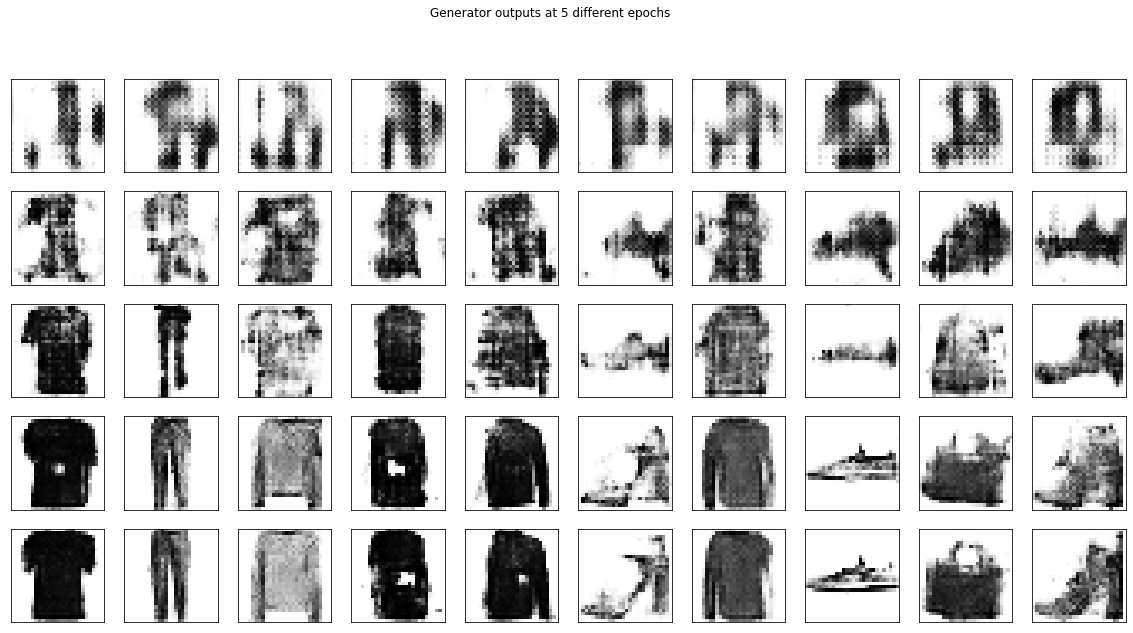

In [ ]:
import matplotlib.pyplot as plt
p = 1
temp = np.array(output)
plt.figure(figsize=(20,10))
plt.suptitle('Generator outputs at 5 different epochs')
for i in range(len(output)):
  for k in range(10):
    plt.subplot(5,10,p)
    plt.imshow(temp[i,k].reshape(28,28),'gray_r')
    plt.xticks([])
    plt.yticks([])
    p = p+1

# Plot losses

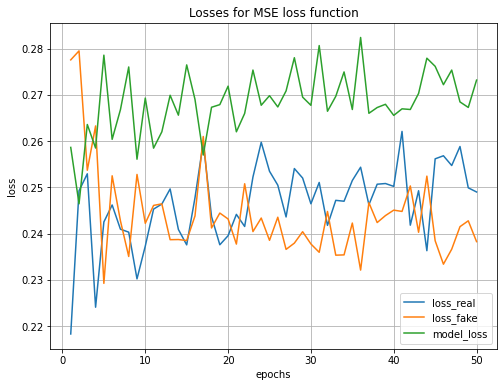

In [ ]:
ep = np.arange(1,51)
plt.figure(figsize=(8,6))
plt.plot(ep,disc_real,label='loss_real')
plt.plot(ep,disc_fake,label='loss_fake')
plt.plot(ep,dc_c_gan_loss,label='model_loss')
plt.title('Losses for MSE loss function')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()